<a href="https://colab.research.google.com/github/Stubberson/project-collection/blob/main/deep-learning/CNN_python" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional neural networks (CNNs)
The notebook follows Francois Chollet's book [Deep Learning with Python (2021)](https://sourestdeeds.github.io/pdf/Deep%20Learning%20with%20Python.pdf). This is chapter 8 of the book. Focus is on computer vision and convolutional neural networks. First, we'll go over how to recognize hand-written digits from the MNIST dataset with a convolutional network.

## The convolution operation
The fundamental difference between a densely connected layer and a convolution layer is this: `Dense` layers learn global patterns in their input feature space (e.g. for an MNIST digit, patterns involving all pixels), whereas convolution layers learn local patterns – in the case of images, patterns found in small 2D windows of the inputs.

This key characteristic gives _convnets_ two interesting properties:
- _The patterns they learn are transalation-invariant_ – After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner. A densely connected model would have to learn the pattern anew if it appeared at a new location.
- _They can learn spatial hierarchies of patterns_ – A first convolution layer will learn small local patterns such as edges, a second convolution layer will learn larger patterns made of the features of the first layers, and so on. This allows convnets to efficiently learn increasingly complex and abstract visual concepts.

Convolutions operate over rank-3 tensors called _feature maps_, with two spatial axes (height and width) as well as a depth axis. For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray). The convolution operation extracts pathches from its input feature map and applies the same transformation to all of these patches, producing an _output feature map_. This output feature map is still a rank-3 tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for _filters_. Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept "presence of a face in the input", for instance.

> In our example, the first convolution layer takes a feature map of size `(28, 28, 1)` and outputs a feature map of size `(26, 26, 32)`: it computes 32 filters over its input. Each of those 32 channels contains a `26 x 26` grid of values, which is a _response map_ of the filter over the input, indicating the response of that filter pattern at different locations in the input. $\to$ Every dimension in the depth axis is a _feature_ (or a filter), and the rank-2 tensor `output[:, :, n]` is the 2D spatial _map_ of the response of this filter over the input.

A convolution works by _sliding_ windows of (often) size `3 x 3` or `5 x 5` over the 3D input feature map, stopping at every possible location, and extracting the 3D patch of surrounding features. Each such 3D patch is then transformed into a 1D vector of shape `(output_depth,)`, which is done via a tensor product with a learned weight matrix, called the _kernel_. All of these vectors (one per patch) are then spatially reassembled into a 3D output map of shape `(height, width, output_depth)`. The output map's width and height are dependent on the `kernel_size` and `padding`: without padding the map shrinks relative to the kernel size.

In [ ]:
# Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

import matplotlib.pyplot as plt
import numpy as np
import os, shutil, pathlib

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
# Load data and normalize the grey values
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)
# Add the grey value channel onto the images
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
print(train_images.shape)
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28)
(60000, 28, 28, 1)


In [ ]:
# Input data are the digit images which are 28x28 pixels and have one channel
inputs = keras.Input(shape=(28, 28, 1))

# Use the Functional API to build our model.
# Outputs a response feature map of size (26, 26, 32), which becomes clear from
# the model summary, but can also be inferred
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
# Outputs are probability distributions over 10 digits
outputs = layers.Dense(10, activation="softmax")(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          11,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,202 (407.04 KB)

 Trainable params: 104,202 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Use the sparse_categorical_crossentropy for non-one-hot encoded classification
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8754 - loss: 0.3960
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9847 - loss: 0.0505
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9900 - loss: 0.0325
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9924 - loss: 0.0236
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9949 - loss: 0.0171


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9912 - loss: 0.0275
Test accuracy: 0.9931


The model's accuracy is extremely good for such a simple architecture! A model consisting only of `Dense` layers caps out on about 97% acccuracy.

We didn't go over the `MaxPooling2D()` layer yet, though. How does it work?

## The max-pooling operation
In the example, we noticed that the size of the feature maps is halved after every MaxPooling2D layer. For instance, before the first MaxPooling2D layers, the feature map is `26 x 26`, but the max-pooling operation halves it to `13 x 13`. That's the role of max pooling: to aggressively downsample feature maps, much like strided convolutions.

Max pooling consists of extracting windows from the input maps and outputting the max value of each channel. It's conceptually similar to convolution, except that instead of transforming local patches via a learned linear transformation (the convolution kernel), they're transformed via a hardcoded `max` tensor operation.

# Training a _convnet_ for cat and dog images
Lets build another convnet, classifying pictures of dogs and cats from a dataset containing 5,000 images of cats and dogs. Let's split the dataset into three:
- a training set with 2,000 images,
- a validation set with 1,000 images, and
- a test set with 2,000 images.

While building the model, we'll look into three different concepts for achieving a better classifying result for small datasets:
- _data augmentation_,
- _feature extraction with a pretrained model_, and
- _fine-tuning a pretrained model_.

## Uploading and preprosessing the dataset structure
I downloaded the _cats and dogs_ dataset from [here](https://www.microsoft.com/en-us/download/details.aspx?id=54765). Then I uploaded the .zip file to my Google Drive, which I can mount onto Colab. From there I can unzip the data onto the Colab `content` directory.

In [ ]:
# Mount my Google Drive to Colab so that I don't have to upload the data every
# time I restart the runtime
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq drive/MyDrive/colab_notebooks/deep_learning_with_python/data/kagglecatsanddogs.zip

The .zip-file contains a parent folder `PetImages` and within that two directories `Cat` and `Dog`. The Cat and Dog directories both contain 12,500 JPEGs of cats and dogs named `0.jpg`, `1.jpg`, ... `12499.jpg`. Thus, in total there are 25,000 images.

The following function is used to create a smaller batch of data from the original 25,000 images.

In [ ]:
original_dir = pathlib.Path("PetImages")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("Cat", "Dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{i}.jpg" for i in range(start_index, end_index)]

        for fname in fnames:
            src_path = original_dir / category / fname
            if src_path.exists():
                shutil.copyfile(src=src_path, dst=dir / fname)
            else:
                print(f"Warning: Source file not found: {src_path}")

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [ ]:
for subset_name in ("train", "validation", "test"):
    for category in ("Cat", "Dog"):
        dir = new_base_dir / subset_name / category
        print(f"Number of files in {dir}: {len(os.listdir(dir))}")

Number of files in cats_vs_dogs_small/train/Cat: 1000
Number of files in cats_vs_dogs_small/train/Dog: 1000
Number of files in cats_vs_dogs_small/validation/Cat: 500
Number of files in cats_vs_dogs_small/validation/Dog: 500
Number of files in cats_vs_dogs_small/test/Cat: 1000
Number of files in cats_vs_dogs_small/test/Dog: 1000


We now have 2,000 training images, 1,000 validation images, and 2,000 test images. Each split contains the same number of samples from each class: this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of error (success).

## Building the model
We will reuse the same general model architecture used in the first example: the convnet will be a stack of alternated `Conv2D` and `MaxPooling2D` layers. But because we're now dealing with bigger images and a more complex problem, we'll make our model larger. This serves both to augment the capacity of the model and to further reduce the size of the feature maps so they aren't overly large when we reach the `Flatten` layer.

Because we're looking at a binary-classification problem, we'll end the model with a single unit (a `Dense` layer of size 1) and a `sigmoid` activation function. This unit will encode the probability that the model is looking at one class or the other. The model will start with a `Rescaling` layer, which will rescale image inputs (original values are in the range \[0, 255]) to the \[0, 1] range.

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))  # Resize all the RGB images to 180x180
x = layers.Rescaling(1. / 255)(inputs)  # Rescale/normalize the color values
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## Data preprocessing
The data should be formatted into appropriately preprocessed floating-point tensors before being fed into a model. Currently, our data sits on the drive as JPEG files, so the stepts for getting it into the model are roughly as follows:
1. Read the picture files
2. Decode the JPEG content to RGB grids of pixels
3. Convert these into floating-point tensors
4. Resize them to a shared size (we'll use 180 x 180)
5. Pack them into batches (we'll use batches of 32 images)

Keras has utilities to take care of these steps automatically. For instance, the utility function `image_dataset_from_directory()` lets you quickly set up a data pipeline that can automatically turn image files on disk into batches of preprocessed tensors.

In [ ]:
# It turns out that there are a couple of corrupted images in the dataset.
# Gemini produced this piece of code for me to detect corrupted files.
# After recognizing the corrupted images,
# I replaced them with images downloaded online.
def check_for_corrupted_images(dir_path):
    for filename in os.listdir(dir_path):
        if filename.endswith(".jpg"):
            filepath = os.path.join(dir_path, filename)
            try:
                # Attempt to decode the image using TensorFlow
                _ = tf.io.decode_image(tf.io.read_file(filepath))
            except tf.errors.InvalidArgumentError:
                print(f"Corrupted image: {filepath}")

# Check for corrupted images in each directory
check_for_corrupted_images(new_base_dir / "train" / "Cat")
check_for_corrupted_images(new_base_dir / "train" / "Dog")
check_for_corrupted_images(new_base_dir / "validation" / "Cat")
check_for_corrupted_images(new_base_dir / "validation" / "Dog")
check_for_corrupted_images(new_base_dir / "test" / "Cat")
check_for_corrupted_images(new_base_dir / "test" / "Dog")

Corrupted image: cats_vs_dogs_small/train/Cat/666.jpg
Corrupted image: cats_vs_dogs_small/test/Dog/2317.jpg
Corrupted image: cats_vs_dogs_small/test/Dog/2494.jpg


In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


What is the ouput of one of these `Dataset` objects (in this case the `train_dataset`)?

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("Data batch shape:", data_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break

Data batch shape: (32, 180, 180, 3)
Labels batch shape: (32,)


Let's fit the model on our dataset. We'll use the `validation_data` argument in `fit()` to monitor validation metrics on a separate `Dataset` object.

We'll also use a `ModelCheckpoint` callback to save the model after each epoch. We'll configure it with the path specifying where to save the file, as well as the arguments `save_best_only=True` and `monitor="val_loss"`: they tell the callback to only save a new file when the current value of the `val_loss` metric is lower than at any previous time during training. This guarantees that your saved file will always contain the state of the model corresponding to its best-performing training epoch, in terms of its performace on the validation data. As a result, we won't have to retrain a new model for a lower number of epochs if we start overfitting: we can just reload our saved file.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - accuracy: 0.5019 - loss: 0.7095 - val_accuracy: 0.5750 - val_loss: 0.6890
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5292 - loss: 0.6932 - val_accuracy: 0.5030 - val_loss: 0.6962
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.5753 - loss: 0.6864 - val_accuracy: 0.5830 - val_loss: 0.7281
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.6571 - loss: 0.6413 - val_accuracy: 0.6450 - val_loss: 0.6195
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6627 - loss: 0.6301 - val_accuracy: 0.6970 - val_loss: 0.5782
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.6996 - loss: 0.5685 - val_accuracy: 0.6500 - val_loss: 0.6917
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7137 - loss: 0.5528 - val_accuracy: 0.6600 - val_loss: 0.6381
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7260 - loss: 0.5394 - val_accuracy: 0.7100 -

## Visualize loss and accuracy during training
Let's plot the loss and accuracy of the model over the training and validation data during training.

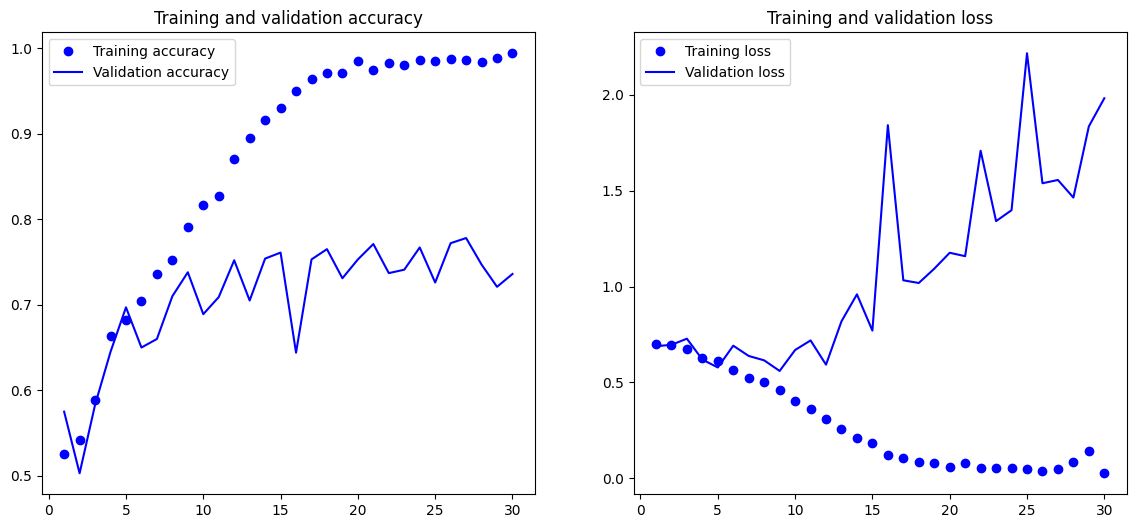

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

These plots are characteristc of overfitting. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy peaks at 75%. The validation loss reaches its minimum after only ten epochs and then stalls, whereas the training loss keeps decreasing linearly as training proceeds.

Let's check the test accuracy. We'll reload the model from its saved file to evaluate it as it was before it started overfitting.

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7155 - loss: 0.5482
Test accuracy: 0.711


## Data augmentation
Not a great accuracy due to the overfitting of our model. Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. _Data augmentation_ takes the approach of generating more training data from existing training samples by _augmenting_ the samples via a number of random transformations that yield believable-looking images. The goal is that, at training time, your model will never see the exact same picture twice. This helps generalization.

In Keras, augmentation can be done by adding a number of data augmentation layers at the start of your model. Let's get started with an example: the following Sequential model chains several random image transformations. In our model, we'd include it right before the `Rescaling` layer.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

These are just a few of the layers available.
- `RandomFlip("horizontal")` – Applies horizontal flipping to a random 50% of the images that go through it
- `RandomRotation(0.1)` – Rotates the input images by a random value in the range [-10%, +10%] (in degrees, the range would be +-36°)
- `RandomZoom(0.2)` – Zooms in or out of the image by a random factor in the range [-20%, -20%]

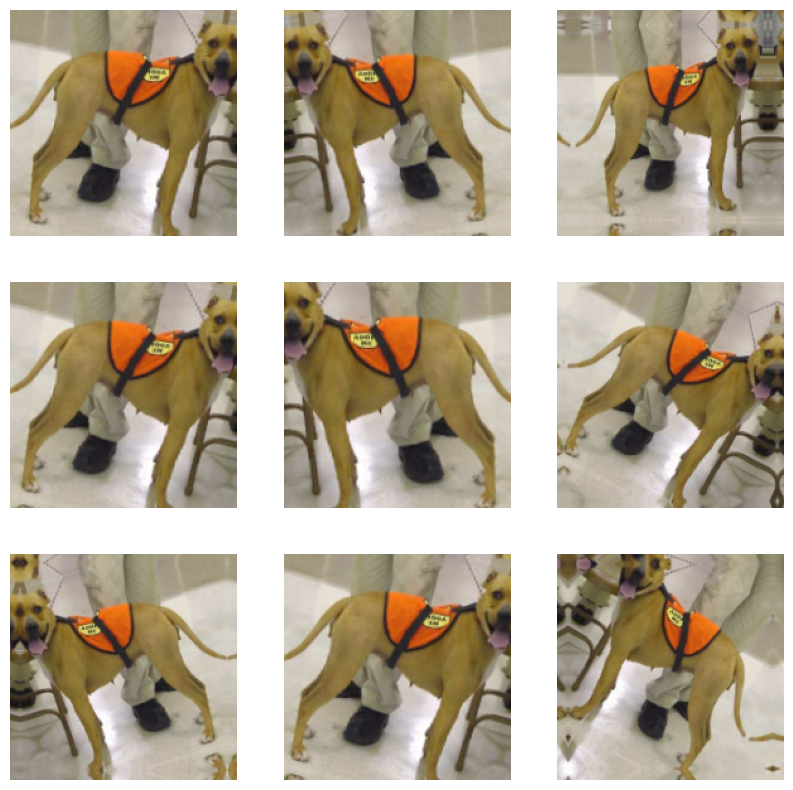

In [ ]:
plt.figure(figsize=(10, 10))
# We can use take(N) to only sample N batches from the dataset. This is
# equivalent to inserting a break in the loop after the Nth batch.
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)  # Apply the augmentation
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))  # Show the first image(s) of the image batch
        plt.axis("off")

If we train a new model using this data-augmentation configuration, the model will never see the same input twice. But the inputs it sees are still heavily intercorrelated because they come from a small number of original images – we can't produce new information; we can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, we'll also add a `Dropout` layer to our model.

Image augmentation layers, just like `Dropout` layers, are inactive during inference (when we call `predict()` or `evaluate()`). During evaluation, our model will behave just the same as when it did not include data augmentation and dropout.

In [ ]:
# New convnet with data augmentation and dropout
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1. / 255)(x)  # Rescale/normalize the color values
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Let's train the model using data augmentation and dropout. Because we expect overfitting to occur much later during training, we will train for three times as many epochs – one hundred.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.4843 - loss: 0.7035 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.5496 - loss: 0.6914 - val_accuracy: 0.6020 - val_loss: 0.6799
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.5994 - loss: 0.6773 - val_accuracy: 0.5990 - val_loss: 0.6622
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.6258 - loss: 0.6617 - val_accuracy: 0.5580 - val_loss: 0.6803
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6205 - loss: 0.6617 - val_accuracy: 0.6410 - val_loss: 0.6274
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6569 - loss: 0.6157 - val_accuracy: 0.6840 - val_loss: 0.6008
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.6909 - loss: 0.5966 - val_accuracy: 0.6550 - val_loss: 0.6080
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7008 - loss: 0.5872 - val_accuracy: 0.

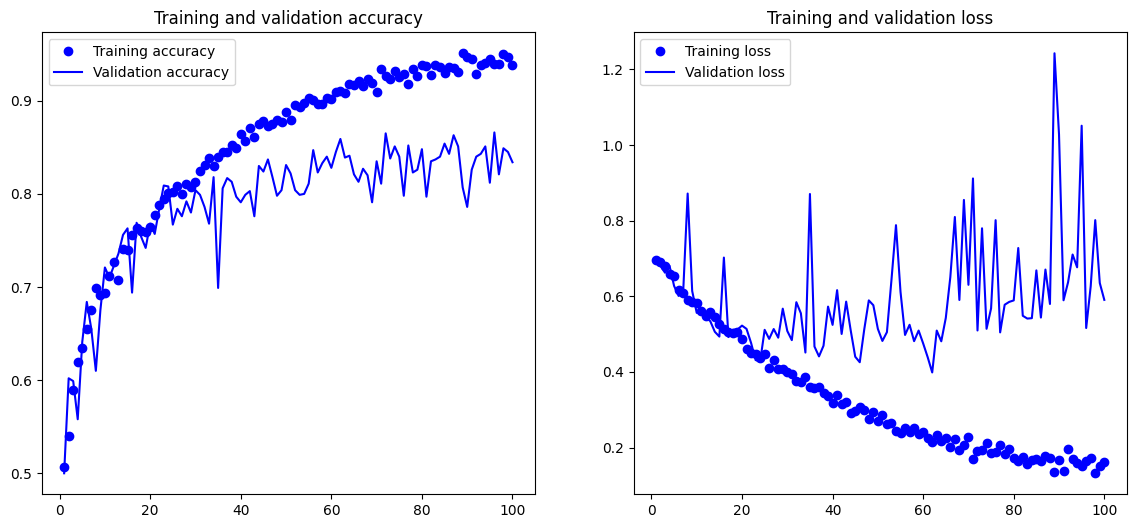

In [ ]:
# Plot the new model's accuracy
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Thnaks to data augmentation and dropout, we start overfitting much later, around epochs 60 (compared to epoch 10 in the previous model). The validation accuracy ends up consistently in the 80-85% range. Check the test accuracy:

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8438 - loss: 0.5326
Test accuracy: 0.851


By further tuning the model's configuration (such as the number of filters per convolution layer, or the number of layers in the model), we might be able to get an even better accuracy. But it would prove difficult to go any higher than about 90% just by training our own convnet from scratch, because we have so little data to work with. As a next step to improve our accuracy on this problem, we'll have to use a pretrained model.

# Leveraging a pretrained model
A common and highly effective approach to deep learning on small image datasets is to use a pretrained model. A _pretrained model_ is a model that was previously trained on a large dataset, typicaly on a large-scale image-classification task. If this original dataset is large enough and general enough, the spatial hierarchy of features learned by the pretrained model can effectively act as a generic model of the visual world, and hence, its features can prove useful for many different computer vision problems, even though these new problems may involve completely different classes than those of the original task.

There are two ways to use a pretrained model: _feature extraction_ and _fine-tuning_.

## Feature extraction
Feature extraction consists of using the representations learned by a previously trained model to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely connected classifier. The first part is called the _convolutional base_ of the model. Feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output.

In general, you should only reuse the convolutional base. The reason is that the representations learned by the convolutional base are likely to be more generic and, therefore, more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which are likely to be useful regardless of the computer vision problem at hand. But the representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained – they will only contain information about the presence probability of a specific class in the entire picture. Additionally, classifier layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps.

> Layers that come earlier in the model extract local, highly generic feature maps (e.g., visual edges, colors, and textures), whereas layers that are "higher up" extract more specific concepts (e.g., cat eye). So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

Let's try out _feature extraction_ with the base of the VGG16 network, trained on ImageNet, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of these features.

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
     # Whether to include the densely connected classifier on top or not. While True this corresponds to the 1,000 classes from ImageNet
    include_top=False,
    input_shape=(180, 180, 3)
)

conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

At this point, there are two ways we could proceed:
- Run the convolutional base over our dataset, record its output to a NumPy array on disk, and then use this data as input to a standalone, densely connected classifier. This technique won't allow for _data augmentation_, but is fairly light computationally.
- Extend the model we have (`conv_base`) by adding `Dense` layers on top, and run the whole thing from end to end on the input data. This will allow us to use data augmentation, because every input image goes through the convolutional base every time it's seen by the model. But for the same reason, this techique is far more expensive than the first.

We'll cover both techniques. First, the ligther version.

In [ ]:
# Extracting the VGG16 features and corresponding labels
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        # VGG16 model expects inputs that are preprocessed, scaling pixel values to an appropriate range
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        # The predict() also only expects images, but in our ..._dataset we have images AND labels
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
train_features.shape

(2000, 5, 5, 512)

At this point, we can define our densely connected classifier and train it on the data and labels that we just recorded.

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data = (val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8686 - loss: 55.0015 - val_accuracy: 0.9620 - val_loss: 5.3434
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9695 - loss: 4.0614 - val_accuracy: 0.9650 - val_loss: 6.3716
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9877 - loss: 2.1277 - val_accuracy: 0.9720 - val_loss: 5.5569
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9863 - loss: 1.5841 - val_accuracy: 0.9650 - val_loss: 7.1548
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9917 - loss: 1.3208 - val_accuracy: 0.9470 - val_loss: 15.2253
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9946 - loss: 0.3819 - val_accuracy: 0.9720 - val_loss: 5.4112
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9956 - loss: 0.5615 - val_accuracy: 0.9730 - val_loss: 5.5488
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9960 - loss: 0.1636 - val_accuracy: 0.9790 - val_lo

Training is very fast because we only have to deal with two `Dense` layers – an epoch takes less than one second even on CPU.

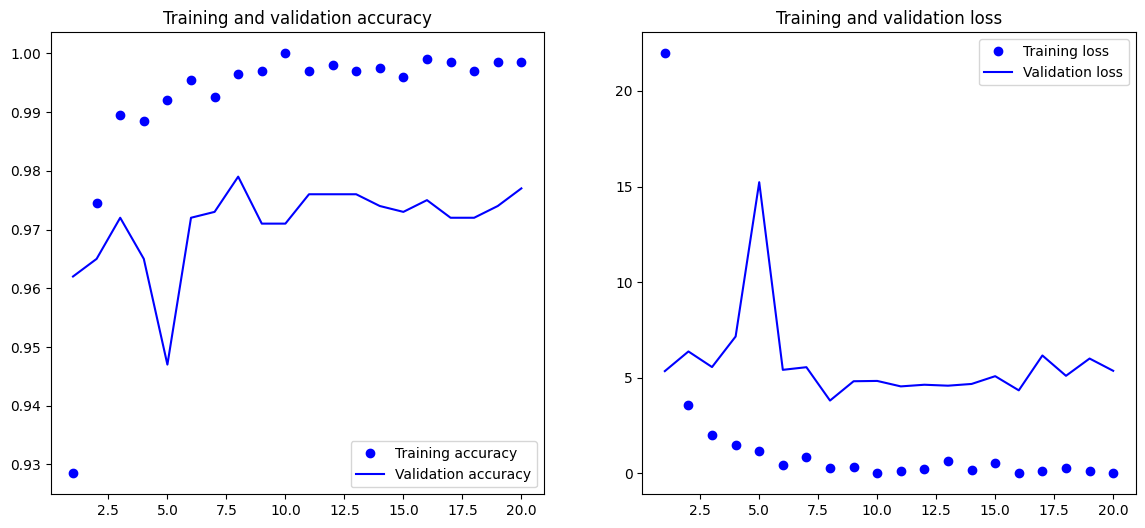

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9677 - loss: 6.9776
Test accuracy: 0.975


We reach a validation accuracy of about 97% – much better than we achieved in the previous sectoin with the small model trained from sctarch. This is a bit of an unfair comparison, however, because ImageNet contains many dog and cat instances, which means that our pretrained model already has the exact knowledge required for the task at hand. This won't always be the case when you use pretrained models.

However, the plots also show that we're overfitting. That's because this technique doesn't use data augmentation, which is essential for preventing overfitting with small image datasets.

---
Let's look at the other feature extraction technique which allows for data augmentation during training: creating a model that chains the `conv_base` with a new dense classifier, and training it end to end on the inputs.

First, we'll _freeze the convolutional base_. Freezing a layer or set of layers means preventing their weights from being updated during training. If we don't do this, the representations that were previously learned by the convolutional base will be modified during training. Because `Dense` layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned. Freezing in Keras happens by setting a model's `trainable` attribute to `False`.

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = False

Now we can create a new model that chains together
1. A data augmentation stage
2. Our frozen convolutional layer
3. A dense classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only = True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data = validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 204ms/step - accuracy: 0.8101 - loss: 36.1222 - val_accuracy: 0.9740 - val_loss: 2.9481
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.9511 - loss: 6.8941 - val_accuracy: 0.9690 - val_loss: 3.1106
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.9540 - loss: 6.3571 - val_accuracy: 0.9730 - val_loss: 3.6345
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accuracy: 0.9604 - loss: 5.6019 - val_accuracy: 0.9800 - val_loss: 3.9191
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.9662 - loss: 3.1535 - val_accuracy: 0.9710 - val_loss: 4.6079
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.9740 - loss: 2.9771 - val_accuracy: 0.9750 - val_loss: 4.9684
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.9590 - loss: 4.4841 - val_accuracy: 0.9790 - val_loss: 3.8092
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.9813 - loss: 1.5997 - val_acc

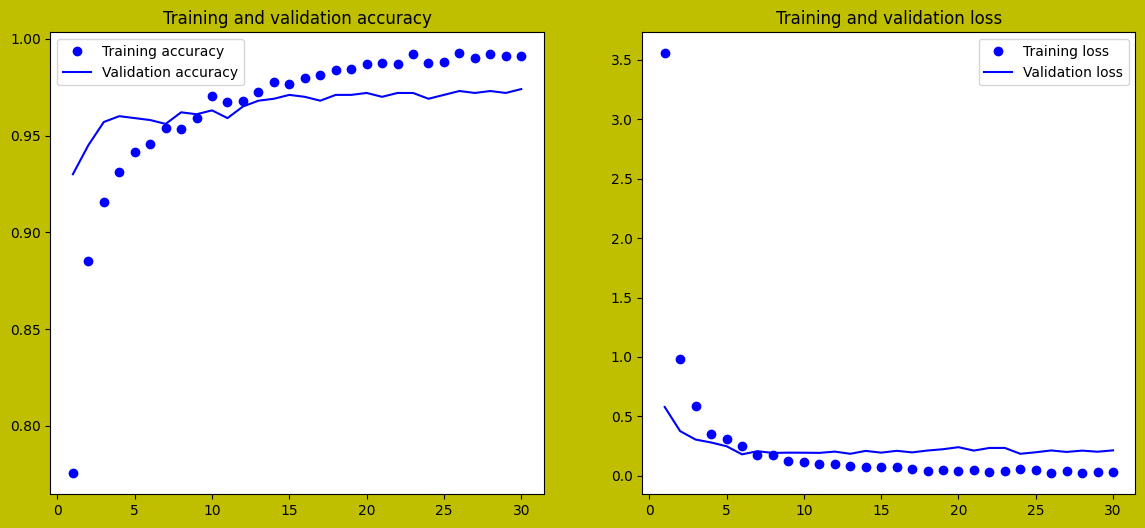

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(14, 6), facecolor="y")
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Let's check the accuracy.

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9668 - loss: 1.9842
Test accuracy: 0.974


## Fine-tuning a pretrained model
Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model and these top layers.

It is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classifier isn't already trained, the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. Thus, the steps for fine-tuning a network are:
1. Add a custom network on top af an already-trained base network
2. Freeze the base network
3. Train the part we added
4. Unfreeze some layers in the base network
5. Jointly train both these layers and the part we added

We'll fine-tune the last three convolutional layers, which means all layers up to `block4_pool` should be frowzen, and the layers `block_conv1`. `block_conv2`, and `block5_conv3` should be trainable (check the `conv_base` summary above for the topology).

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? You need to consider the follwing:
- Earlier layers in the convolutional base encode more generic, reusable features, whereas layers higher up encode more specialized features. It's more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on your new problem. There would be fast-decreasing returns in fine-tuning lower layers.
- The more parameteres you're training, the more you're at risk of overfitting. The convolutional base has 15 million parameters, so it woild be risky to attempt to train it on your small dataset.

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# Freeze the network until the 4 last layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - accuracy: 0.7232 - loss: 5.1713 - val_accuracy: 0.9300 - val_loss: 0.5791
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.8802 - loss: 1.1009 - val_accuracy: 0.9450 - val_loss: 0.3756
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.9127 - loss: 0.6949 - val_accuracy: 0.9570 - val_loss: 0.3048
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.9308 - loss: 0.4221 - val_accuracy: 0.9600 - val_loss: 0.2804
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 0.9395 - loss: 0.3192 - val_accuracy: 0.9590 - val_loss: 0.2487
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - accuracy: 0.9506 - loss: 0.2346 - val_accuracy: 0.9580 - val_loss: 0.1807
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.9530 - loss: 0.1619 - val_accuracy: 0.9560 - val_loss: 0.2067
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.9520 - loss: 0.1520 - val_accu

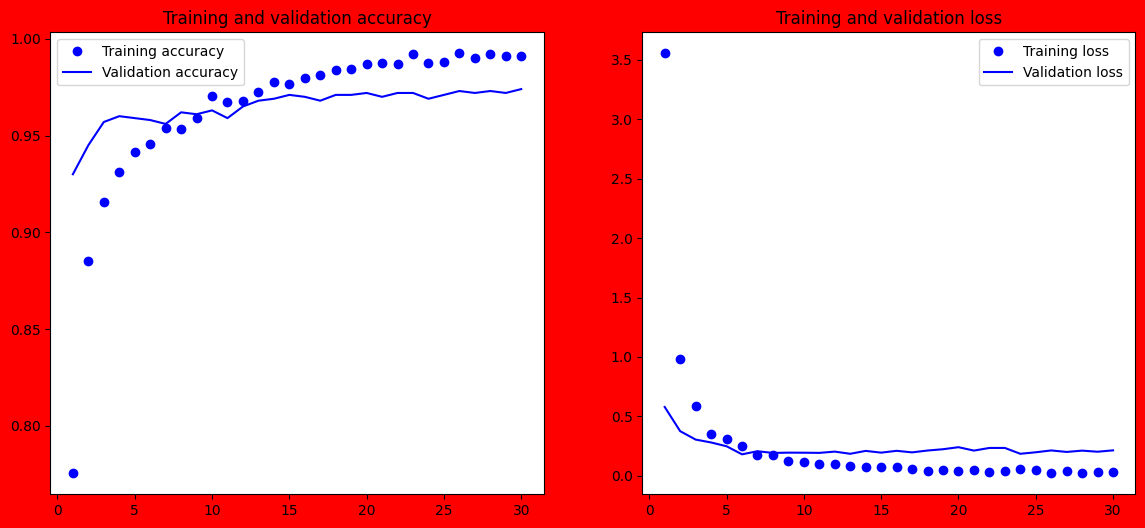

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(14, 6), facecolor="r")
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.9680 - loss: 0.1733
Test accuracty: 0.971


A test accuracy of 97%. We managed to reach this result using only a relatively small dataset with _data augmentation_, _feature extraction_ and _fine-tuning_.

## Conclusions
- Convnets are the best type of machine learning models for computer vision tasks. It's possible to train one from scratch even on a very small dataset, with decent results.
- Convnets work by learning a hierarchy of modular patterns and concepts to represent the visual world
- On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when you're working with image data.
- It's easy to reuse an existing convnet on a ne wdataset via fearture extraction. This is a valuable technique for working with small image datasets.
- As a complement to feature extraction, you can use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.